In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
import re
from multiprocessing import Pool
import nltk
import string
from nltk.tokenize import casual_tokenize,TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.pipeline import Pipeline as Pipeline_imb

In [3]:
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import TransformerMixin

In [6]:
pd.set_option('display.max_colwidth',-1)
% matplotlib inline
plt.style.use('seaborn-pastel')
pd.options.display.max_colwidth = -1

### Dataset from https://www.kaggle.com/speckledpingu/RawTwitterFeeds
### Description:
This is a dataset of tweets from various active scientists and personalities ranging from Donald Trump and Hillary Clinton to Neil deGrasse Tyson. The data was scraped using JavaScript directly off of Twitter's website and has been dumped from JSON into CSV using Pandas read_json and to_csv feature.


Twitter is an online news and social networking service on which users post and interact with messages known as "tweets". Tweets were originally restricted to 140 characters, but on November 7, 2017, this limit was doubled. 
### Task:
Is 140 characters enough to identify their author?

Identify the author of tweet accoring to analysis of tweets's content (with usernames cleaned)

### 1. Reading data

In [7]:
df = pd.read_csv('Data/famous_tweets/AllTweets.csv',usecols=['text','author','link'])

In [8]:
df.head(5)

,link,text,author
0,/NASA/status/787029214612586496,New software on the @Space_Station will make data communications faster and easier for hundreds of scientists: http://go.nasa.gov/2dQrLto pic.twitter.com/weIfEomT9x,NASA
1,/NASA/status/787008587927281664,READY for Launch! @OrbitalATK's #Antares rocket & cargo ship set to lift off at 8:03pm ET Sunday to @Space_Station: http://go.nasa.gov/2egj5e9 pic.twitter.com/pwB3mYIrrP,NASA
2,/NASA/status/787042156116664320,Rocket launch at 8:03pm ET Sunday to deliver cargo to @Space_Station. Are you in the launch viewing area? More: http://go.nasa.gov/2egB9Vw pic.twitter.com/eKMHk7eHRV,NASA
3,/NASA/status/787284414732472320,What happened this week at NASA? @POTUS outlined space exploration's future. Also highlighted: #WHFrontiers Conference & @NASA_Orion. Watch:pic.twitter.com/4UxeBWVhee,NASA
4,/NASA/status/786934496625102848,Energize! Study makes sure astronauts have energy they need. Watch our @Space_Station update. Q? Use #SpaceToGround. https://youtu.be/oKZvYztlpp4 pic.twitter.com/vo8HUB17Wm,NASA


### 2. Analysis of authors

In [9]:
df.shape

(88625, 3)

In [10]:
df.isnull().sum() # check null values

link      0
text      0
author    0
dtype: int64

In [11]:
df.author.value_counts()

DonaldTrump        17216
NASA               15910
KimKardashian      10688
various            10440
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
ScottKelly         1219 
Name: author, dtype: int64

### 2.1 What are "various" authors?

In [12]:
various_authors = [a[1] for a in df.loc[df.author == 'various','link'].str.split('/')]

In [13]:
df.loc[df.author == 'various','author'] = various_authors

In [14]:
author_stats = df.author.value_counts()

In [15]:
len(author_stats)# there are 2416 authors

2416

In [16]:
author_stats[:15]# we are taking into consideration authors with more than one thousand of tweets

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
datascigeek        667  
chi2innovations    364  
eelrekab           352  
innova_scape       237  
Name: author, dtype: int64

In [17]:
names = np.array(author_stats[author_stats > 1000].index)

In [18]:
df = df.loc[df.author.isin(names)]

In [19]:
df.author.value_counts()# check

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
Name: author, dtype: int64

In [20]:
print("Dataset contains {} tweets".format(df.shape[0]))

Dataset contains 79757 tweets


In [21]:
print("There are {} authors of more than one thousand tweets. ".format(len(names)))

There are 11 authors of more than one thousand tweets. 


### 2.2 Statistics for authors

In [22]:
author_counts = df.author.value_counts()
print(author_counts / author_counts.sum())

DonaldTrump        0.215856
NASA               0.199481
KimKardashian      0.134007
FiveThirtyEight    0.122384
BarackObama        0.086463
RichardDawkins     0.073210
AdamSavage         0.061086
HillaryClinton     0.042078
deGrasseTyson      0.030442
kdnuggets          0.019710
ScottKelly         0.015284
Name: author, dtype: float64


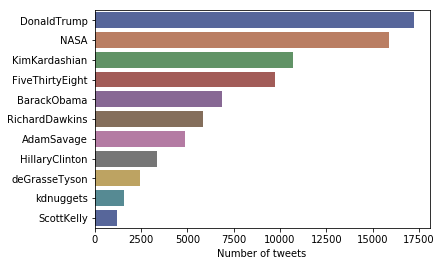

In [23]:
sns.barplot(x = author_counts.values,y = names,alpha = 0.7,orient="h",palette='dark')
plt.xlabel('Number of tweets');

### Note: 
Inbalanced dataset with 11 authors and number of tweets ranging from 1.2 thousand up to 17.2 thousand.

### 2.3 Converting author's name to categorical veriable

In [24]:
df.author = df.author.astype('category')

In [25]:
df.author.cat.categories

Index(['AdamSavage', 'BarackObama', 'DonaldTrump', 'FiveThirtyEight',
       'HillaryClinton', 'KimKardashian', 'NASA', 'RichardDawkins',
       'ScottKelly', 'deGrasseTyson', 'kdnuggets'],
      dtype='object')

### 3. Splitting into train and test datasets

In [26]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.author,test_size = 0.2,stratify = df.author)

In [27]:
y_train.value_counts()

DonaldTrump        13773
NASA               12728
KimKardashian      8550 
FiveThirtyEight    7809 
BarackObama        5517 
RichardDawkins     4671 
AdamSavage         3897 
HillaryClinton     2685 
deGrasseTyson      1942 
kdnuggets          1258 
ScottKelly         975  
Name: author, dtype: int64

### 3. Preprocessing

### 3.1  Text cleaning - no hashtags, urls, pictures' links

Removing:
- "#" hashtags,
- "@" at sign,
- urls,
- pictures links


na razie usuwamy wszystie tagi i linki 

na razie nie usuwamy imion

In [28]:
# może jednak trzeba usunąć
ind = 1011
print(cleaned_tweets[ind])
print(processed_tweets[ind])
print(tokens_length[ind])
print(words_count[ind])

NameError: name 'cleaned_tweets' is not defined

In [29]:
class TweetCleaner(TransformerMixin):
    def __init__(self,process=2):
        self.process = process 
        
    def cleaning_text(self,tweet):
        '''
        removes urls, pictures,# hashtags,@ at signs from tweet
        return cleaned tweet, number of urls, pictures, # hastaags, @ at signs 
        '''
        #urls
        regex = re.compile(r'http[s]*://[\w.\-/\\]+')
        url = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        #pictures
        regex = re.compile(r'pic.*')
        pic = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '#'hashtags
        regex = re.compile(r'#\w+')
        hashtag = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '@'at signs
        regex = re.compile(r'@\w+')
        at_sign = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # multiple whitespaces
        tweet = re.sub(r'\s{2,}','',tweet)

        return tweet,url,pic,hashtag,at_sign
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        pool = Pool(self.process)
        result = pool.map(self.cleaning_text,X)
        pool.close()
        pool.join()
        
        cleaned_tweets = [res[0] for res in result]
        urls = [res[1] for res in result]
        pics = [res[2] for res in result]
        hashtags = [res[3] for res in result]
        at_signs = [res[4] for res in result]
        
        X_out = pd.DataFrame({
            'text':cleaned_tweets,
            'urls':urls,
            'pics':pics,
            'hashtags':hashtags,
            'at_signs':at_signs
        })
        
        return X_out
    

In [30]:
cleaner = TweetCleaner(2)

In [31]:
X_cleaned = cleaner.fit_transform(X_train)

In [32]:
X_cleaned.head()

,text,urls,pics,hashtags,at_signs
0,"To all those who wondered what boots I wore for Dumpster Diving, they were cheap, (150.00) leather, and bought on Haight St. Brand: Demonia.",0,0,0,0
1,""":How important do you think college is? Especially during these times..""Very important",0,0,0,2
2,I find the photos of these children killed in Newtown in the New York Post heartbreaking.,0,0,1,0
3,I've realized that success requires 100% effort and 100% focus. Nothing less.,0,0,0,0
4,Fall colors busted out all over Pennsylvania this week. Check out these images from our Aqua satellite.,1,0,0,0


### 3.3 Tokenization

In [33]:
class TweetProcessor(TransformerMixin):
    def __init__(self,process=2):
        self.process = process 
       
    def processing_text(self,tweet,stopwords,stemmer):
        '''
        removes punctuation, stopwords, converts to stems 
        returns cleaned text, average length of words in tweet and number of words in tweet
        '''
        # remove cappital letters
        tweet = tweet.lower()

        # tokenizer for informal text
        tokens = casual_tokenize(tweet)

        # remove punctuation
        tokens_no_punct = [token for token in tokens if not token in string.punctuation]

        # number of words in tweet
        words_count = len(tokens_no_punct)

        # average length of words in tweet
        token_len = [len(token) for token in tokens_no_punct]
        if len(token_len) > 0 :
            aver_len = np.array(token_len).mean()
        else:
            aver_len = 0

        #remove stopwords
        tokens_no_stopwords = [token for token in tokens_no_punct if not token in stopwords]

        #stemming
        stems = [stemmer.stem(token) for token in tokens_no_stopwords]

        return ' '.join(stems),aver_len,words_count

    def fit(self,X,y=None):
        # find text column
        self.key = X.select_dtypes(exclude='number').columns[0]
        return self
    
    def transform(self,X,y=None):
        
        X = X.copy()
        
        X_text = X.pop(self.key)
        
        stopwords = nltk.corpus.stopwords.words('english')
        porter_stemmer = PorterStemmer()
        snawball_stemmer = SnowballStemmer('english')
        
        pool = Pool(self.process)
        results = pool.map(partial(self.processing_text,stopwords=stopwords,stemmer=porter_stemmer),X_text)
        pool.close()
        pool.join()
        
        processed_tweets = [res[0] for res in results]
        tokens_length = [res[1] for res in results]
        words_count = [res[2] for res in results]
        
        X_out = pd.DataFrame({
            'text':processed_tweets,
            'tokens_length':tokens_length,
            'words_count':words_count,
        })
    
        return pd.concat([X,X_out],axis=1)

In [34]:
processor = TweetProcessor(2)

In [35]:
X_proc = processor.fit_transform(X_cleaned)

In [36]:
X_proc.head()

,urls,pics,hashtags,at_signs,text,tokens_length,words_count
0,0,0,0,0,wonder boot wore dumpster dive cheap 150.00 leather bought haight st brand demonia,4.541667,24
1,0,0,0,2,import think colleg especi time .. import,5.142857,14
2,0,0,1,0,find photo children kill newtown new york post heartbreak,4.562500,16
3,0,0,0,0,i'v realiz success requir 100 effort 100 focu noth less,5.166667,12
4,1,0,0,0,fall color bust pennsylvania week check imag aqua satellit,5.000000,17


In [ ]:
ind = 1011
print(cleaned_tweets[ind])
print(processed_tweets[ind])
print(tokens_length[ind])
print(words_count[ind])

### 4. Classification

### Undersample to optimize vectorizer parameters
### TF-IDF + NaiveBayes

In [42]:
X_proc.shape

(63805, 7)

In [43]:
y_train.shape

(63805,)

In [ ]:
pipe = Pipeline_imb([
    ('vectorizer',TfidfVectorizer()),
    ('resampling',SMOTE()),
    ('bayes',MultinomialNB())
])
param_bayes = {
    'vectorizer__min_df':[10,20,50],
    'vectorizer__max_df':[0.2,0.3,0.5,0.7],
    'resampling__k_neighbors':[3,5],
    'resampling__m_neighbors':[7,10],
    'bayes__alpha':[0.01,0.1,1.0]
}

In [ ]:
pipe = Pipeline_imb([
    ('vectorizer',TfidfVectorizer()),
    ('resampling',SMOTE()),
    ('bayes',MultinomialNB())
])
param_bayes = {
    'vectorizer__min_df':[10,20,50],
    'vectorizer__max_df':[0.2,0.3,0.5,0.7],
    'resampling__k_neighbors':[3,5],
    'resampling__m_neighbors':[7,10],
    'bayes__alpha':[0.01,0.1,1.0]
}

In [ ]:
grid = GridSearchCV(estimator=pipe,
                   param_grid = param_bayes,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=KFold(5,shuffle=True))

In [ ]:
grid.fit(processed_tweets_small.flatten(),y_train_small)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_score_

### 3.4 Bag of words

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.2,min_df=20)

In [ ]:
bow = vectorizer.fit_transform(processed_tweets)

In [ ]:
bow.shape

### 4. Resampling imablanced dataset

In [ ]:
y_train.value_counts()

In [ ]:
smote = SMOTE(n_jobs=2)

In [ ]:
bow_res,y_train_res = smote.fit_sample(bow,y_train)

In [ ]:
y_train_resS = pd.Series(y_train_res)

In [ ]:
y_train_resS.value_counts()

In [ ]:
bow_res.shape

In [ ]:
svd = TruncatedSVD(n_components=1000)
bow_svd_ = svd.fit_transform(bow_res)

In [ ]:
np.sum(svd.explained_variance_ratio_)

In [ ]:
scaler = MinMaxScaler()
bow_scaled = scaler.fit_transform(bow_svd_)

In [ ]:
bow_svd_.shape

In [ ]:
bayes = MultinomialNB?

In [ ]:
bayes = MultinomialNB

In [ ]:
bayes.fit(bow_scaled,y_train_res)

In [ ]:
accuracy_score(y_train_res,bayes.predict(bow_scaled))

In [ ]:
y_pred = bayes.predict(bow_scaled)

In [ ]:
print(classification_report(y_true=y_train_res,y_pred=y_pred,labels=names))

In [ ]:
cm = confusion_matrix(y_true=y_train_res,y_pred=y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=names,yticklabels=names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
ind_min = 15
ind_max = 30
for ind in range(ind_min,ind_max):
    print(X_train.iloc[ind])
    print()

In [ ]:
print(X_train[y_train == 'KimKardashian'][520:540])

### KDNuggets

In [ ]:
df_kd = pd.read_csv('Data/famous_tweets/10460KDNuggetsTweets.csv')

In [ ]:
df_kd.head(50)

In [ ]:
df_kd.shape

In [ ]:
df_kd2 = df.loc[df.author == 'kdnuggets']

In [ ]:
df_kd2.head()

In [ ]:
df_rd = df.loc[df.author == 'RichardDawkins']

In [ ]:
df_rd.head(10)

### Adam Savage

In [ ]:
df_savage = pd.read_csv('Data/famous_tweets/AdamSavageTweets.csv',usecols=['link','text'])

In [ ]:
df_savage.shape

In [ ]:
df_savage.head()

### Obama

In [ ]:
df_obama = pd.read_csv('Data/famous_tweets/BarackObama.csv',usecols=['link','text'])

In [ ]:
df_obama.shape

### Trump

In [ ]:
df_trump = pd.read_csv('Data/famous_tweets/DonaldTrumpTweets.csv',usecols=['link','text'])

In [ ]:
df_trump.shape

### FiveThirtyEight

In [ ]:
df_539 = pd.read_csv('Data/famous_tweets/FiveThirtyEightTweets.csv',usecols=['link','text'])

In [ ]:
df_539.shape

### Tyson

In [ ]:
df_tyson = pd.read_csv('Data/famous_tweets/NeildeGrasseTysonTweets.csv',usecols=['link','text'])

In [ ]:
df_tyson.shape

### Ricahrd Dawkins

In [ ]:
df_dawkins = pd.read_csv('Data/famous_tweets/RichardDawkins.csv',usecols=['link','text'])

In [ ]:
df_dawkins.shape

### Clinton

In [ ]:
df_clinton = pd.read_csv('Data/famous_tweets/HillaryClintonTweets.csv')

In [ ]:
df_clinton.shape

In [ ]:
df_kim = pd.read_csv('Data/famous_tweets/KimKardashianTweets.csv')

In [ ]:
df_kim.shape

In [ ]:
df_kelly = pd.read_csv('Data/famous_tweets/ScottKelly.csv')
df_kelly.shape

In [ ]:
id_min = 10
id_max = 50
for ind in range(id_min,id_max):
    print(df_539.text[ind])